# Import library

In [ ]:
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import as_strided as conv2d_map
import warnings
np.seterr(all='raise')

# Plot result
import seaborn as sns
import matplotlib.pylab as plt

# Datetime is used for saving file
from datetime import datetime

# Colab is used for saving files
from google.colab import files

# Download Dataset and Preprocess

## Mnist Dataset
http://yann.lecun.com/exdb/mnist/

#### Download Dataset

In [ ]:
!rm -r mnist
!mkdir mnist
!wget -O ./mnist/training_images.gz http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget -O ./mnist/training_labels.gz http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget -O ./mnist/testing_images.gz http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget -O ./mnist/testing_labels.gz http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

rm: cannot remove 'mnist': No such file or directory
--2020-12-16 12:15:28--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.28.7.204, 104.28.6.204, 172.67.171.76, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.28.7.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘./mnist/training_images.gz’

./mnist/training_im 100%[===================>]   9.45M  59.0MB/s    in 0.2s    

2020-12-16 12:15:28 (59.0 MB/s) - ‘./mnist/training_images.gz’ saved [9912422/9912422]

--2020-12-16 12:15:28--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.28.6.204, 104.28.7.204, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘./mnist/training_labels.gz’

./mnist/

#### Preprocess

In [ ]:
import gzip

train_img = gzip.open('./mnist/training_images.gz','r')
test_img = gzip.open('./mnist/testing_images.gz','r')
train_label = gzip.open('./mnist/training_labels.gz','r')
test_label = gzip.open('./mnist/testing_labels.gz','r')

image_size = 28
train_num = 60000
test_num = 10000

""" Format training images """
train_img.read(16)
buf = train_img.read(image_size * image_size * train_num)
train_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
train_data = train_data.reshape(train_num, image_size, image_size, 1)
train_data = np.asarray(train_data).squeeze()

""" Format testing images """
test_img.read(16)
buf = test_img.read(image_size * image_size * test_num)
test_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
test_data = test_data.reshape(test_num, image_size, image_size, 1)
test_data = np.asarray(test_data).squeeze()

""" Flattern images """
mnist_train_data = train_data
mnist_test_data = test_data

""" Bound to 0 and 1 """
mnist_train_data /= 255
mnist_test_data /= 255

""" Format training labels """
train_label.read(8)
train_target = np.zeros((train_num))
for i in range(0,train_num):   
    buf = train_label.read(1)
    train_target[i] = int.from_bytes(buf, "big")

test_label.read(8)
test_target = np.zeros((test_num))
for i in range(0,test_num):   
    buf = test_label.read(1)
    test_target[i] = int.from_bytes(buf, "big")

""" Label One hot encoding """
mnist_train_label = np.zeros((train_num, 10))
for i in range(train_target.shape[0]):
  num = int(train_target[i])
  mnist_train_label[i,num] = 1

mnist_test_label = np.zeros((test_num, 10))
for i in range(test_target.shape[0]):
  num = int(test_target[i])
  mnist_test_label[i,num] = 1

In [ ]:
mnist_train_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

# Network


## Function class

In [ ]:
class model_func():
  epsilon = 1e-9  # Deal with unstable value
  clip_exp = 700
  """ Activation function """
  @classmethod
  def relu(cls, z):
    return np.maximum(0,z)

  @classmethod
  def d_relu(cls, z):
    return np.where(z<=0, 0, 1)

  @classmethod
  def sigmoid(cls, z):
    z = np.clip(z, -cls.clip_exp, cls.clip_exp)
    return 1/(1+np.exp(-z))

  @classmethod
  def d_sigmoid(cls, z):
    z = np.clip(z, -cls.clip_exp, cls.clip_exp)
    s = 1/(1+np.exp(-z))
    return s*(1-s)

  @classmethod
  def softmax(cls, z):
    tmp_z = z - max(z)
    numerator = np.exp(tmp_z)
    return numerator/np.sum(numerator)

  @classmethod
  def d_softmax(cls, z):
    d_z = np.diag(z)
    for i in range(len(d_z)):
      for j in range(len(d_z)):
        if i == j:
          d_z[i][j] = z[i] * (1-z[i])
        else: 
          d_z[i][j] = -z[i]*z[j]
    return d_z

  @classmethod
  def linear(cls, z):
    return z
  
  @classmethod
  def d_linear(cls, z):
    return 1

  """ Loss function """
  @classmethod
  def mean_squared_error(cls, z, target):
    loss = 0.5*(z - target)**2
    d_loss = z - target
    return loss, d_loss

  @classmethod
  def binary_cross_entropy(cls, z, target):
    z = np.clip(z, cls.epsilon, 1-cls.epsilon)
    if target == 1:
      loss = -np.log(z)
    else:
      loss = -np.log(1-z)
    d_loss = (z-target)/(z*(1-z))
    return loss, d_loss

  @classmethod
  def cross_entropy(cls, z, target):
    z = np.clip(z, cls.epsilon, 1-cls.epsilon)
    loss = -np.sum(target*np.log(z))
    d_loss = -target/z
    return loss, d_loss

  @classmethod
  def softmax_cross_entropy_derivative(cls, z, target):
    z = np.clip(z, cls.epsilon, 1-cls.epsilon)
    loss = -np.sum(target*np.log(z))
    d_loss = z - target
    return loss, d_loss

  """ Accuracy calculation """
  @classmethod
  def binary_accuracy(cls, z, target):
    predict = np.where(z >= 0.5, 1, 0)
    return np.mean(predict==target)

  @classmethod
  def categorical_accuracy(cls, z, target):
    predict = (z == z.max(axis=1)[:,None]).astype(int)
    return np.mean(np.all(predict == target, axis=1)) 

## Full connected layer

In [ ]:
class fc_layer():
  def __init__(self, n_neuron, n_input, activation="relu"):
    self.n_neuron = n_neuron                    # Number of neuron in this FC layer
    self.n_input = n_input+1                    # Number of previous layer neuron, plus 1 bias
    self.out = np.zeros(self.n_neuron)           #　Output of each neuron after activation
    self.d_out = np.zeros(self.n_neuron)         #　Derivative of activation
    self.weight = (np.random.randn(self.n_input, self.n_neuron) / np.sqrt(self.n_input)).T # Xavier weight initialization
    self.d_weight = np.zeros((self.n_neuron, self.n_input)) # Delta of weights
    self.bp_z = np.zeros(n_input)               # The output value to next layer during backward path
    self.fp_input = np.zeros(self.n_input)      # The input of layer during fordward path
    self.fp_input[-1] = 1                       # Set bias to constant 1
    self.bp_precal = False

    # Set up activation function
    assert activation in {'relu', 'sigmoid', 'softmax', 'linear'}
    if activation == "relu":
      self.activation = model_func.relu
      self.d_activation = model_func.d_relu
    elif activation == "sigmoid":
      self.activation = model_func.sigmoid
      self.d_activation = model_func.d_sigmoid
    elif activation == "softmax":
      self.activation = model_func.softmax
      self.d_activation = model_func.d_softmax
    elif activation == "linear":
      self.activation = model_func.linear
      self.d_activation = model_func.d_linear

  def update_weight(self):
    """ Update weight """
    self.weight = self.weight + self.d_weight
    self.d_weight.fill(0)

  def forward(self, fp_input):
    """ Calculate weight*input value, namely z """
    self.fp_input[0:-1] = fp_input
    z = np.dot(self.weight, self.fp_input)
    self.out = self.activation(z)
    self.d_out = self.d_activation(z)

  def backward(self, bp_input, lr):
    """ Calculate the increment value of weight and the output to next layer during bp """
    if self.bp_precal == False:
      de_dz = bp_input * self.d_out
    else:
      de_dz = bp_input
    self.bp_z = np.dot(self.weight[:,0:-1].T, de_dz)
    d_weight = np.outer(de_dz, self.fp_input)
    self.d_weight = self.d_weight - lr * d_weight
  
  def get_weight(self):
    return ["fc_layer" ,self.weight]

  def load_weight(self, weight):
    if len(weight) != 1 or weight[0].shape != self.weight.shape:
      raise RuntimeError("Error, shape not match")
    else:
      self.weight = weight[0]

## Convolution layer

In [ ]:
class conv2d_layer():
  def __init__(self, input_shape, n_filter, filter_size=(1,1), strides=(1,1), activation="relu"):
    """
    input_shape - shape of input feature map, would be depth x height x width
    filter_size - shape of filter, would be (width x height)
    """
    if len(input_shape) != 3:
      raise RuntimeError("Input shape shpuld be a 3-D array which contains [channel, height, width]")

    self.filter_size = np.array( [filter_size[1],filter_size[0]] )  # Height, Width
    self.strides = np.array( [strides[1],strides[0]] )  # Height, Width

    # Weight Initialization
    filter_shape = (n_filter, input_shape[0], self.filter_size[0], self.filter_size[1]) # Filter - nparray, shape should be (num_filter, depth, height, width)
    self.weight = self.glorot_uniform(filter_shape)
    self.d_weight = np.zeros(self.weight.shape)

    self.weight_bias = np.random.randn(n_filter)/np.sqrt(n_filter)
    self.weight_bias = self.weight_bias.reshape((n_filter,1,1))
    self.d_weight_bias = np.zeros(self.weight_bias.shape)

    # Output initialization
    output_length = np.subtract(input_shape[1:], self.weight.shape[2:]) + 1
    output_length = (output_length + self.strides - 1) // self.strides

    out_shape = np.array((n_filter, output_length[0], output_length[1])) # (num_fmap, height, width)
    self.out = np.zeros(out_shape)
    self.d_out = np.zeros(out_shape)

    # Backpropagation setting
    self.bp_pad = self.filter_size - 1
    self.bp_z = np.zeros(input_shape)
    self.valid_length = 1 + self.strides * (output_length - 1) + np.subtract(self.weight.shape[2:],1)

    dilate_size = np.where(out_shape[1:]>2, out_shape[1:]-1, 1)
    dilated_bp_size = out_shape[1:] + dilate_size*(self.strides-1)
    gradient_size = dilated_bp_size + self.bp_pad*2
    self.extand_gradient = np.zeros((out_shape[0], gradient_size[0], gradient_size[1]))

    # Convolution Map setting
    t_weight_shape = self.weight.transpose(0, 1, 3, 2).shape[2:]
    self.for_map_shape = self.weight.shape[1:] + tuple(np.subtract(input_shape, self.weight.shape[1:]) + 1)
    self.back_dw_shape = (input_shape[0],) + tuple(dilated_bp_size) + (1,) + tuple(np.subtract(self.valid_length, dilated_bp_size) + 1)
    self.back_dz_shape = (self.extand_gradient.shape[0],)+ t_weight_shape + (1,) + tuple(np.subtract(self.extand_gradient.shape[1:], t_weight_shape) + 1)

    # Set up activation function
    assert activation in {'relu', 'sigmoid', 'linear'}
    if activation == "relu":
      self.activation = model_func.relu
      self.d_activation = model_func.d_relu
    elif activation == "sigmoid":
      self.activation = model_func.sigmoid
      self.d_activation = model_func.d_sigmoid
    elif activation == "linear":
      self.activation = model_func.linear
      self.d_activation = model_func.d_linear
    
  # CNN Xavier Glorot's initialization functions
  def get_fans(self, shape):
    """ shape: (num_filter, depth, height, width) """
    fan_in = np.prod(shape[1:])
    fan_out = shape[0]
    return fan_in, fan_out

  def glorot_uniform(self, shape):
    """ Reference: Glorot & Bengio, AISTATS 2010 """
    fan_in, fan_out = self.get_fans(shape)
    s = np.sqrt(6. / (fan_in + fan_out))
    return np.random.uniform(size=shape, high=s, low=-s)

  def update_weight(self):
    """ Update weight """
    self.weight = self.weight + self.d_weight
    self.d_weight.fill(0)

    self.weight_bias = self.weight_bias + self.d_weight_bias
    self.d_weight_bias.fill(0) 

  def forward(self, fp_input):
    """
    2D convolution over feature maps

    param  fp_input - nparray, shape should be (depth, height, width)
    note  conv - nparray, shape is (num_fmap, height, width)
    note  depth of fp_input should be equal to depth of filter
    """
    self.fp_input = fp_input

    subM = conv2d_map(self.fp_input, shape=self.for_map_shape, strides=self.fp_input.strides*2, writeable=False)
    conv = np.einsum('ijkl,jklmno->ino', self.weight, subM[..., ::self.strides[0], ::self.strides[1]]) # The last to dimension is each 2D feature map

    z = conv + self.weight_bias
    self.out = self.activation(z)
    self.d_out = self.d_activation(z)

  def backward(self, bp_input, lr):

    self.extand_gradient.fill(0)
    self.extand_gradient[:, self.bp_pad[0]:-self.bp_pad[0]:self.strides[0], self.bp_pad[1]:-self.bp_pad[1]:self.strides[1]] = bp_input

    # Weight change
    dilated_bp_input = self.extand_gradient[:, self.bp_pad[0]:-self.bp_pad[0], self.bp_pad[1]:-self.bp_pad[1]]
    valid_input = self.fp_input[:, :self.valid_length[0], :self.valid_length[1]]

    subM = conv2d_map(valid_input, shape=self.back_dw_shape, strides=valid_input.strides*2, writeable=False)
    d_weight = np.einsum('ikl,jklmno->ijno', dilated_bp_input, subM)
    self.d_weight = self.d_weight - lr * d_weight

    d_weight_bias = np.sum(dilated_bp_input, axis=(1,2)).reshape(self.d_weight_bias.shape)
    self.d_weight_bias = self.d_weight_bias - lr * d_weight_bias

    # Gradient
    subM = conv2d_map(self.extand_gradient, shape=self.back_dz_shape, strides=self.extand_gradient.strides*2, writeable=False)
    conv = np.einsum('ijkl,iklmno->jno', self.weight.transpose(0, 1, 3, 2), subM)
    self.bp_z[:conv.shape[0],:conv.shape[1],:conv.shape[2]] = conv

  def get_weight(self):
    return ["conv2d", self.weight, self.weight_bias]

  def load_weight(self, weight):
    if len(weight) != 2 or weight[0].shape != self.weight.shape or weight[1].shape != self.weight_bias.shape:
      raise RuntimeError("Error, shape not match")
    else:
      self.weight = weight[0]
      self.weght_bias = weight[1]

## Flattern Layer

In [ ]:
class flattern():
  def __init__(self, input_shape):
    """
    input_shape - shape of input feature map, would be depth x height x width
    """
    if len(input_shape) != 3:
      raise RuntimeError("Input shape shpuld be a 3-D array which contains [channel, height, width]")

    self.input_shape = input_shape
    output_length = input_shape[0]*input_shape[1]*input_shape[2]
    self.n_neuron = output_length

  def update_weight(self):
    pass
  def forward(self, fp_input):
    self.out = fp_input.reshape(self.n_neuron)
  def backward(self, bp_input, lr):
    self.bp_z = bp_input.reshape(self.input_shape)
  def get_weight(self):
    return ["flattern"]

## Average pooling layer

In [ ]:
class average_pooling2d():
  def __init__(self, input_shape, pool_size=(2,2), strides=(1,1)):
    """
    input_shape - shape of input feature map, would be depth x height x width
    pool_size - shape of filter, would be (width x height)
    """
    if len(input_shape) != 3:
      raise RuntimeError("Input shape shpuld be a 3-D array which contains [channel, height, width]")

    self.pool_size = np.array( [pool_size[1],pool_size[0]] )  # Height, Width
    self.strides = np.array( [strides[1],strides[0]] )  # Height, Width

    # Weight Initialization
    filter_value = 1/(pool_size[0]*pool_size[1])
    filter_shape = (1, input_shape[0], self.pool_size[0], self.pool_size[1]) # Filter - nparray, shape should be (num_filter, depth, height, width)
    self.weight = np.full(shape=filter_shape, fill_value=filter_value)

    # Output initialization
    output_length = np.subtract(input_shape[1:], self.weight.shape[2:]) + 1
    output_length = (output_length + self.strides - 1) // self.strides

    out_shape = np.array((input_shape[0], output_length[0], output_length[1])) # (depth, height, width)
    self.out = np.zeros(out_shape)

    # Backpropagation setting
    self.bp_pad = self.pool_size - 1
    self.bp_z = np.zeros(input_shape)

    dilate_size = np.where(out_shape[1:]>2, out_shape[1:]-1, 1)
    gradient_size = out_shape[1:] + dilate_size*(self.strides-1) + self.bp_pad*2
    self.extand_gradient = np.zeros((out_shape[0], gradient_size[0], gradient_size[1]))

    # Convolution Map setting
    t_weight_shape = self.weight.transpose(0, 1, 3, 2).shape[2:]
    self.for_map_shape = self.weight.shape[1:] + tuple(np.subtract(input_shape, self.weight.shape[1:]) + 1)
    self.back_dz_shape = (self.extand_gradient.shape[0],)+ t_weight_shape + (1,) + tuple(np.subtract(self.extand_gradient.shape[1:], t_weight_shape) + 1)

  def update_weight(self):
    pass

  def forward(self, fp_input):
    self.fp_input = fp_input

    subM = conv2d_map(self.fp_input, shape=self.for_map_shape, strides=self.fp_input.strides*2, writeable=False)
    self.out = np.einsum('ijkl,jklmno->jno', self.weight, subM[..., ::self.strides[0], ::self.strides[1]]) # The last to dimension is each 2D feature map

  def backward(self, bp_input, lr=0):
    self.extand_gradient.fill(0)
    self.extand_gradient[:, self.bp_pad[0]:-self.bp_pad[0]:self.strides[0], self.bp_pad[1]:-self.bp_pad[1]:self.strides[1]] = bp_input

    # Gradient
    subM = conv2d_map(self.extand_gradient, shape=self.back_dz_shape, strides=self.extand_gradient.strides*2, writeable=False)
    conv = np.einsum('ijkl,jklmno->jno', self.weight.transpose(0, 1, 3, 2), subM)
    self.bp_z[:conv.shape[0],:conv.shape[1],:conv.shape[2]] = conv

  def get_weight(self):
    return ["averagepooling2d"]

## RBF Layer

In [ ]:
class rbf_Layer():
  def __init__(self, RBF="gaussian", center=None, sigma=None, c_lr=0.001, s_lr=0.001):
    # Parameter attribute
    if RBF == "gaussian":
      self.RBF = self.forward_Gaussian;
      self.backward = self.backward_Gaussian
    elif RBF == "multiquadratic":
      self.RBF = self.forward_Multiquadratic
      self.backward = self.backward_Multiquadratic
    elif RBF == "inverse_multiquadric":
      self.RBF = self.forward_Inverse_Multiquadric
      self.backward = self.backward_Inverse_Multiquadric
    elif RBF == "inverse_quadratic":
      self.RBF = self.forward_Inverse_Quadratic
      self.backward = self.backward_Inverse_Quadratic
    else:
      raise RuntimeError("Unknown RBF kernel {}".format(RBF))
    
    self.c_lr = c_lr
    self.s_lr = s_lr

    if center is not None:
      self.center = center
      self.sigma = sigma
      self.n_neuron = center.shape[0]   # Output shape, prepared for next layer
    
    self.d_center = np.zeros(center.shape) # Accumulated Center change
    self.d_sigma = np.zeros(sigma.shape)  # Accumulated Sigma change
    self.min_data = 1e-9           # Minimum accepted value of RBF
    self.first_input = None         # The previous input
    self.out = np.zeros(center.shape[0])  # Output of the RBF kernel        

  # Update the weight with accumulated value
  def update_weight(self):
    self.center = self.center + self.d_center
    self.d_center = np.zeros(self.center.shape)

    self.sigma = self.sigma + self.d_sigma
    self.d_sigma = np.zeros(self.sigma.shape)

  def forward(self, input):
    self.first_input = input
    self.RBF(input)

  # Different forward RBF kernel
  def forward_Gaussian(self, fp_input):
    var1 = -np.sum((fp_input-self.center)**2, axis=1)/(2*self.sigma**2)
    var2 = np.exp(var1)
    var3 = np.where(var2<=self.min_data, self.min_data, var2)
    self.out = var3

  def forward_Multiquadratic(self, fp_input):
    var1 = np.sqrt(np.sum((fp_input-self.center)**2, axis=1)+self.sigma**2)
    self.out = var1

  def forward_Inverse_Multiquadric(self, fp_input):
    var1 = np.sqrt(np.sum((fp_input-self.center)**2, axis=1)+self.sigma**2)
    self.out = 1/var1

  def forward_Inverse_Quadratic(self, fp_input):
    var1 = np.sum((fp_input-self.center)**2, axis=1)+self.sigma**2
    self.out = 1/var1

  # Different derivative of RBF kernel
  def backward_Gaussian(self, bp_input, lr):
    de_dz = bp_input

    # Calculate center position change
    d_center_var1 = de_dz * self.out
    d_center_var2 = self.center - self.first_input
    d_center = -1 * (d_center_var2.T * (d_center_var1 / self.sigma**2)).T
    self.d_center = self.d_center - lr*self.c_lr*d_center

    # Calculate sigma value change
    d_sigma = d_center_var1 * np.sum((d_center_var2**2),axis=1) / (self.sigma**3)
    self.d_sigma = self.d_sigma - lr*self.s_lr*d_sigma

  def backward_Multiquadratic(self, bp_input, lr):
    de_dz = bp_input

    # Calculate center position change
    d_center = ((self.center - self.first_input).T * (de_dz / self.out)).T
    self.d_center = self.d_center - lr*self.c_lr*d_center

    # Calculate sigma value change
    d_sigma = de_dz * self.sigma / self.out
    self.d_sigma = self.d_sigma - lr*self.s_lr*d_sigma

  def backward_Inverse_Multiquadric(self, bp_input, lr):
    de_dz = bp_input

    # Calculate center position change
    d_center = (-(self.center - self.first_input).T * (de_dz * self.out**3)).T
    self.d_center = self.d_center - lr*self.c_lr*d_center

    # Calculate sigma value change
    d_sigma = de_dz * -self.sigma * self.out**3
    self.d_sigma = self.d_sigma - lr*self.s_lr*d_sigma

  def backward_Inverse_Quadratic(self, bp_input, lr):
    de_dz = bp_input

    # Calculate center position change
    d_center = (-2 * (self.center - self.first_input).T * (de_dz * self.out**2)).T
    self.d_center = self.d_center - lr*self.c_lr*d_center

    # Calculate sigma value change
    d_sigma = -2 * de_dz * self.sigma * self.out**2
    self.d_sigma = self.d_sigma - lr*self.s_lr*d_sigma

## Model class

In [ ]:
class sequential():
  def __init__(self):
    self.n_layer = []

  def add_fc(self, n_neuron, input_width=None, activation="relu"):
    """ Add fully connected layer into model """
    if len(self.n_layer) == 0:
      if input_width is None:
        raise RuntimeError("The input width of input layer must be provided")
      else:
        tmp_layer = fc_layer(n_neuron, input_width, activation)
    else:
      if input_width is not None:
        warnings.warn("The input width of hidden layer will not be used.")
      else:
        tmp_layer = fc_layer(n_neuron, self.n_layer[-1].n_neuron, activation)
    self.n_layer.append(tmp_layer)
  
  def add_rbf(self, RBF="gaussian", center=None, sigma=None, c_lr=0.01, s_lr=0.01):
    """ Add a RBF layer into model """
    if len(self.n_layer) != 0:
      raise RuntimeError("The RBF layer must be the first layer.")
    else:
      tmp_layer = rbf_Layer(RBF=RBF, center=center, sigma=sigma, c_lr=c_lr, s_lr=s_lr)
    self.n_layer.append(tmp_layer)

  def add_conv2d(self, n_filter, filter_size=(3,3), input_width=None, strides=(1,1), activation="relu"):
    if len(self.n_layer) == 0:
      if input_width is None:
        raise RuntimeError("The input width of input layer must be provided")
      else:
        tmp_layer = conv2d_layer(input_shape=input_width, n_filter=n_filter, filter_size=filter_size, strides=strides, activation=activation)
    else:
      if input_width is not None:
        pwarnings.warn("The input width of hidden layer will not be used.")
      else:
        tmp_layer = conv2d_layer(input_shape=self.n_layer[-1].out.shape, n_filter=n_filter, filter_size=filter_size, strides=strides, activation=activation)
    self.n_layer.append(tmp_layer)

  def add_flattern(self, input_width=None):
    if len(self.n_layer) == 0:
      if input_width is None:
        raise RuntimeError("The input width of input layer must be provided")
      else:
        tmp_layer = flattern(input_shape=input_width)
    else:
      if input_width is not None:
        warnings.warn("The input width of hidden layer will not be used.")
      else:
        tmp_layer = flattern(input_shape=self.n_layer[-1].out.shape)
    self.n_layer.append(tmp_layer)

  def add_averagepooling2d(self, input_width=None, pool_size=(2,2), strides=(1,1)):
    if len(self.n_layer) == 0:
      if input_width is None:
        raise RuntimeError("The input width of input layer must be provided")
      else:
        tmp_layer = average_pooling2d(input_shape=input_width, pool_size=pool_size, strides=strides)
    else:
      if input_width is not None:
        warnings.warn("The input width of hidden layer will not be used.")
      else:
        tmp_layer = average_pooling2d(input_shape=self.n_layer[-1].out.shape, pool_size=pool_size, strides=strides)
    self.n_layer.append(tmp_layer)

  def forward_path(self, input):
    """ Calculate forward path value """
    for i in range(len(self.n_layer)):
      if i == 0:
        self.n_layer[i].forward(input)
      else:
        self.n_layer[i].forward(self.n_layer[i-1].out)
  
  def backword_path(self, d_loss, learning_rate):
    """ Back propagation path """
    for i in range(len(self.n_layer)-1, -1, -1):
      if i != len(self.n_layer)-1:
        self.n_layer[i].backward(self.n_layer[i+1].bp_z, lr=learning_rate)
      else:
        self.n_layer[i].backward(d_loss, lr=learning_rate)

  def predict(self, input):
    """ Predict output """
    predict = np.zeros((input.shape[0], self.n_layer[-1].n_neuron))
    for idx,data in enumerate(input):
      self.forward_path(data)
      predict[idx] = self.n_layer[-1].out
    return predict

  def score(self, predict, target):
    """ Scoring function """
    if predict.shape != target.shape:
      raise RuntimeError("Predict shape and expected shape not match. {} v.s. {}".format(predict.shape, target.shape))
    else:
      return np.mean(np.all(predict == target, axis=1))

  def fit(self, input, target, max_iter=1000, learning_rate=0.01, batch_size=1, optimizer=None, loss="mean_squared_error", accuracy="skip"):

    """ Decide loss function """
    assert loss in {'mean_squared_error', 'cross_entropy', 'softmax', 'binary_cross_entropy'}
    if loss == "mean_squared_error":
      self.loss_function = model_func.mean_squared_error
    elif loss == "cross_entropy":
      if self.n_layer[-1].n_neuron != target.shape[-1]:
        raise RuntimeError("Target dimension doesn't match. Target:{} and Output layer neuron:{}".format(target.shape[-1], self.n_layer[-1].n_neuron))
      if self.n_layer[-1].activation == model_func.softmax:
        self.n_layer[-1].bp_precal = True
        self.loss_function = model_func.softmax_cross_entropy_derivative
      else:
        self.loss_function = model_func.cross_entropy
    elif loss == "binary_cross_entropy":
      if self.n_layer[-1].n_neuron != 1:
        raise RuntimeError("Output dimension is not equal to 1. Output layer neuron:{}".format(self.n_layer[-1].n_neuron))
      self.loss_function = model_func.binary_cross_entropy

    """ Decide accuracy function """
    output_dimension = self.n_layer[-1].n_neuron
    assert accuracy in {'category', 'skip'}
    if accuracy == "category":
      if output_dimension == 1:
        self.accuracy_function = model_func.binary_accuracy
      else:
        self.accuracy_function = model_func.categorical_accuracy
    elif accuracy == "skip":
      self.accuracy_function = None

    self.history = np.zeros((max_iter,2))

    for i in range(max_iter):
      cnt = 0
      epoch_accuracy = np.zeros(((input.shape[0]-1)//batch_size+1, 2))
      batch_record_output = np.zeros((2,batch_size,output_dimension))
      batch_record_loss = np.zeros((batch_size))
      for idx,data in enumerate(input):
        # Forward path
        self.forward_path(data)
        # Calculate loss
        loss, d_loss = self.loss_function(self.n_layer[-1].out, target[idx])
        # Backward path
        self.backword_path(d_loss=d_loss, learning_rate=learning_rate)

        # Append predict and expected value
        batch_record_output[0,cnt] = self.n_layer[-1].out
        batch_record_output[1,cnt] = target[idx]
        batch_record_loss[cnt] = loss
        cnt += 1 # Increment batch counter

        # End of batch
        if cnt == batch_size or idx == len(input)-1:
          for layer in self.n_layer: layer.update_weight()  # Update all weight
          if self.accuracy_function is not None:
            epoch_accuracy[idx//batch_size, 0] = self.accuracy_function(batch_record_output[0,0:cnt], batch_record_output[1,0:cnt]) # Calculate precision
          epoch_accuracy[idx//batch_size, 1] = np.mean(batch_record_loss[0:cnt]) # Calculate average loss over a batch
          cnt = 0 # Reset counter
      # End of epoch
      self.history[i,0] = np.mean(epoch_accuracy[:,0])
      self.history[i,1] = np.mean(epoch_accuracy[:,1])
      print("Iteration:{}, Precision:{}, Loss:{}".format(i,self.history[i,0],self.history[i,1]))

  def get_weight(self):
    weights = []
    for idx,layer in enumerate(self.n_layer):
      weights.append(layer.get_weight())
    return weights
  
  def load_weight(self, weights):
    if len(weights) != len(self.n_layer):
      raise RuntimeError("Weight and model not match")
    for idx,layer in enumerate(self.n_layer):
      weight = weights[idx]
      if len(weight) == 1:
        pass
      else:
        self.n_layer[idx].load_weight(weight[1:])

# Create model

In [ ]:
!mkdir mnist_result

## Training

In [ ]:
input_data = mnist_train_data
input_data = input_data.reshape((input_data.shape[0],1,28,28))
target = mnist_train_label

cy_mnist_model = sequential()
lr = 0.0001

cy_mnist_model.add_conv2d(n_filter=2, filter_size=(4,4), input_width=(1,28,28), strides=(1,1), activation="sigmoid")
#cy_mnist_model.add_averagepooling2d(pool_size=(2,2), strides=(1,1))
cy_mnist_model.add_flattern()
cy_mnist_model.add_fc(n_neuron=128, activation="relu")
cy_mnist_model.add_fc(n_neuron=10, activation="softmax")

cy_mnist_model.fit(input_data[0:1000], target[0:1000], max_iter=15, learning_rate=lr, batch_size=64, loss="cross_entropy",accuracy="category")


now = datetime.now() # current date and time
date_time = now.strftime("%m-%d-%Y,%H:%M")
np.save('./mnist_result/history_'+date_time,cy_mnist_model.history)
#files.download('./mnist_result/history_'+date_time+'.npy')

weights = cy_mnist_model.get_weight()
np.savez('./mnist_result/weights_'+date_time+'.npz', weight=weights)
#files.download('./mnist_result/weights_'+date_time+'.npz')

Iteration:0, Precision:0.1126953125, Loss:2.3273692164524453
Iteration:1, Precision:0.1505859375, Loss:2.292453012937824
Iteration:2, Precision:0.1822265625, Loss:2.2752722934814242
Iteration:3, Precision:0.19609375, Loss:2.2622189622014512
Iteration:4, Precision:0.2177734375, Loss:2.2503548371403364
Iteration:5, Precision:0.249609375, Loss:2.238015116431196
Iteration:6, Precision:0.294140625, Loss:2.224261585831045
Iteration:7, Precision:0.333984375, Loss:2.2086275418458063
Iteration:8, Precision:0.3740234375, Loss:2.190532026326541
Iteration:9, Precision:0.4259765625, Loss:2.1694366045164095
Iteration:10, Precision:0.46640625, Loss:2.145077356186297
Iteration:11, Precision:0.4958984375, Loss:2.1171089349999948
Iteration:12, Precision:0.5326171875, Loss:2.0850168617447675
Iteration:13, Precision:0.5814453125, Loss:2.049264366050199
Iteration:14, Precision:0.61328125, Loss:2.0101049569130396


## Testing

In [ ]:
input_data = mnist_test_data
target = mnist_test_label

# Create model
cy_mnist_test_model = sequential()
cy_mnist_test_model.add_conv2d(n_filter=6, filter_size=(3,3), input_width=(1,28,28), strides=(1,1), activation="relu")
cy_mnist_test_model.add_averagepooling2d(pool_size=(2,2), strides=(1,1))
cy_mnist_test_model.add_flattern()
cy_mnist_test_model.add_fc(n_neuron=64, activation="relu")
cy_mnist_test_model.add_fc(n_neuron=10, activation="softmax")

# Load weight
weights = np.load('./mnist_result/weights_12-15-2020,02:45.npz',allow_pickle=True)['weight']
cy_mnist_test_model.load_weight(weights)

# Predict
predict = cy_mnist_test_model.predict(input_data.reshape(10000,1,28,28))

predict = (predict == predict.max(axis=1)[:,None]).astype(int)
cy_mnist_test_model.score(predict, target)

0.5558

## Plot curve

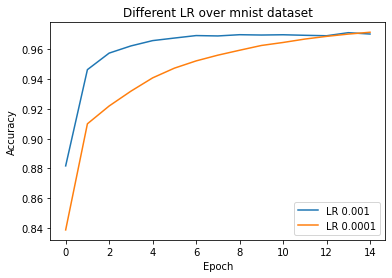

In [ ]:
folder = "./mnist_result/"

lr1 = np.load(folder+'history_12-14-2020,16:07.npy')
lr2 = np.load(folder+'history_12-15-2020,02:45.npy')

plt.plot(lr1[:,0], label="LR 0.001")
plt.plot(lr2[:,0], label="LR 0.0001")

plt.title("Different LR over mnist dataset")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

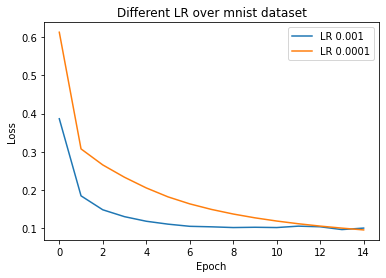

In [ ]:
folder = "./mnist_result/"

lr1 = np.load(folder+'history_12-14-2020,16:07.npy')
lr2 = np.load(folder+'history_12-15-2020,02:45.npy')

plt.plot(lr1[:,1], label="LR 0.001")
plt.plot(lr2[:,1], label="LR 0.0001")

plt.title("Different LR over mnist dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Create Feature Extraction Model
Extract the convolutional layer from the CNN we just trained

In [ ]:
lr_0001_weight = './mnist_result/weights_12-14-2020,16:07.npz'
lr_00001_weight = './mnist_result/weights_12-15-2020,02:45.npz'

weights = np.load(lr_00001_weight, allow_pickle=True)['weight']
new_weights = np.delete(weights, [3,4])

cy_mnist_feature_extractor = sequential()
lr = 0.001
cy_mnist_feature_extractor.add_conv2d(n_filter=6, filter_size=(3,3), input_width=(1,28,28), strides=(1,1), activation="relu")
cy_mnist_feature_extractor.add_averagepooling2d(pool_size=(2,2), strides=(1,1))
cy_mnist_feature_extractor.add_flattern()
cy_mnist_feature_extractor.load_weight(new_weights)

In [ ]:
feature = cy_mnist_feature_extractor.predict(mnist_train_data.reshape(60000,1,28,28))
feature.shape

(60000, 3750)

## K-means

In [ ]:
def k_means(input, max_k=None, max_iter=10, threshold=0.1, min_size=2):
  if max_k is not None:
    desired_k = max_k
  else:
    desired_k = int(input.shape[0]/10)+1
  indices = np.random.choice(input.shape[0], desired_k) # Random sampling
  kmeans_input = input.copy()
  center = kmeans_input[indices]

  belonging = np.zeros((input.shape[0]))
  # K-means iteration
  print("Start K-means, initial center: {}".format(desired_k))
  for i in range(max_iter):
    agg_center_idx = np.zeros((center.shape[0]))
    agg_d_center = np.zeros((center.shape))
    for idx,d in enumerate(kmeans_input):
      dist = np.linalg.norm(d-center,axis=1)
      nearest_idx = np.argmin(dist)
      agg_d_center[nearest_idx] += d
      agg_center_idx[nearest_idx] += 1
      belonging[idx] = nearest_idx

    # Calculate update
    n_center = np.zeros(center.shape)
    for c in range(center.shape[0]):
      if agg_center_idx[c] == 0:
        n_center[c] = center[c]
      else:
        n_center[c] = agg_d_center[c]/agg_center_idx[c]

    # Calculate difference
    delta_dist = np.linalg.norm(n_center-center, axis=1)
    print("Performing K-means Iteration {}".format(i+1))
    if (delta_dist <= threshold).all():
      small_cluster_idx = np.where(agg_center_idx<min_size)
      if agg_center_idx[small_cluster_idx].any():
        n_tiny_cluster = np.count_nonzero(small_cluster_idx)
        center = np.delete(center, small_cluster_idx, axis=0)
        print("K-means converges at iter{}, tiny cluster detected, remain class:{}".format(i+1, center.shape[0]))
      else:
        print("K-means converges at iter{}".format(i+1))
        break
    else:
      center = n_center

  # Set new center and calculate standard deviation
  sigma = np.zeros((center.shape[0]))
  for idx,c in enumerate(center):
    cluster_data = kmeans_input[np.where(belonging==idx)]
    sigma[idx] = np.sqrt(np.sum((cluster_data - c)**2))
  
  # Remove zero sigma center
  zero_sigma_cluster = np.where(sigma==0)
  center = np.delete(center, zero_sigma_cluster,axis=0)
  sigma = np.delete(sigma, zero_sigma_cluster,axis=0)
  print("Remove zero sigma cluster, remaining cluster: {}".format(center.shape[0]))

  return center, sigma

# CNN + RBF Classifier

In [ ]:
input_data = feature
sample = np.random.randint(60000, size=2000)
center, sigma = k_means(input=input_data[sample], max_k=300, max_iter=100, threshold=0.1, min_size=5)

Start K-means, initial center: 300
Performing K-means Iteration 1
Performing K-means Iteration 2
Performing K-means Iteration 3
Performing K-means Iteration 4
Performing K-means Iteration 5
Performing K-means Iteration 6
Performing K-means Iteration 7
Performing K-means Iteration 8
Performing K-means Iteration 9
Performing K-means Iteration 10
Performing K-means Iteration 11
K-means converges at iter11, tiny cluster detected, remain class:191
Performing K-means Iteration 12
Performing K-means Iteration 13
Performing K-means Iteration 14
Performing K-means Iteration 15
Performing K-means Iteration 16
K-means converges at iter16, tiny cluster detected, remain class:190
Performing K-means Iteration 17
Performing K-means Iteration 18
Performing K-means Iteration 19
Performing K-means Iteration 20
Performing K-means Iteration 21
K-means converges at iter21
Remove zero sigma cluster, remaining cluster: 190


In [ ]:
# Generate random sample
sample = np.random.randint(60000, size=6000)

In [ ]:
RBF = "gaussian"

cy_mnist_rbfn_model = sequential()
cy_mnist_rbfn_model.add_rbf(RBF=RBF, center=center, sigma=sigma, c_lr=50, s_lr=50);
cy_mnist_rbfn_model.add_fc(n_neuron=10, activation="softmax")
lr = 0.001
cy_mnist_rbfn_model.fit(input=feature[sample], target=mnist_train_label[sample], max_iter=50, learning_rate=lr, batch_size=64, 
                        loss="cross_entropy",accuracy="category")

Iteration:0, Precision:0.146484375, Loss:2.295948368396325
Iteration:1, Precision:0.220703125, Loss:2.2037468555823843
Iteration:2, Precision:0.2705078125, Loss:2.1306588335611245
Iteration:3, Precision:0.30029296875, Loss:2.0684018004780245
Iteration:4, Precision:0.3232421875, Loss:2.0144658305135708
Iteration:5, Precision:0.3466796875, Loss:1.9669736679551229
Iteration:6, Precision:0.36474609375, Loss:1.9245516075770197
Iteration:7, Precision:0.38037109375, Loss:1.8861940743534151
Iteration:8, Precision:0.40576171875, Loss:1.8511564705259143
Iteration:9, Precision:0.41796875, Loss:1.818878390419139
Iteration:10, Precision:0.43115234375, Loss:1.7889305121729984
Iteration:11, Precision:0.44677734375, Loss:1.7609781260544637
Iteration:12, Precision:0.45849609375, Loss:1.7347559280614822
Iteration:13, Precision:0.47119140625, Loss:1.7100503778450342
Iteration:14, Precision:0.48388671875, Loss:1.6866871620501167
Iteration:15, Precision:0.4990234375, Loss:1.664522143742873
Iteration:16, Pr

In [ ]:
# Load test data
input_data = mnist_test_data
target = mnist_test_label

# Extract feature
feature = cy_mnist_feature_extractor.predict(input_data.reshape(10000,1,28,28))

# Predict
predict = cy_mnist_rbfn_model.predict(feature)
predict = (predict == predict.max(axis=1)[:,None]).astype(int)
cy_mnist_rbfn_model.score(predict, target)

0.7073

In [ ]:
# Save center, sigma, nn weight, history
np.save('./mnist_result/'+"0.0001center_"+RBF,cy_mnist_rbfn_model.n_layer[0].center)
np.save('./mnist_result/'+"0.0001sigma_"+RBF,cy_mnist_rbfn_model.n_layer[0].sigma)
np.save('./mnist_result/'+"0.0001nn_"+RBF,cy_mnist_rbfn_model.n_layer[1].weight)
np.save('./mnist_result/0.0001'+RBF,cy_mnist_rbfn_model.history)

In [ ]:
# Download file
files.download('./mnist_result/'+"0.0001center_"+RBF+'.npy')
files.download('./mnist_result/'+"0.0001sigma_"+RBF+'.npy')
files.download('./mnist_result/'+"0.0001nn_"+RBF+'.npy')
files.download('./mnist_result/0.0001'+RBF+'.npy')

## Plot curve

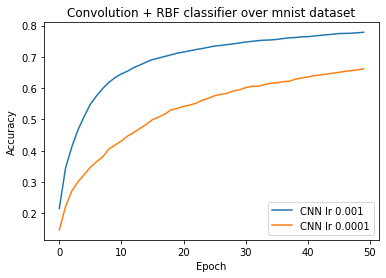

In [ ]:
lr1 = np.load('./mnist_result/0.001'+RBF+'.npy')
lr2 = np.load('./mnist_result/0.0001'+RBF+'.npy')

plt.plot(lr1[:,0], label="CNN lr 0.001")
plt.plot(lr2[:,0], label="CNN lr 0.0001")

plt.title("Convolution + RBF classifier over mnist dataset")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

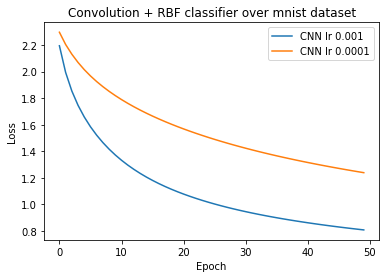

In [ ]:
lr1 = np.load('./mnist_result/0.001'+RBF+'.npy')
lr2 = np.load('./mnist_result/0.0001'+RBF+'.npy')

plt.plot(lr1[:,1], label="CNN lr 0.001")
plt.plot(lr2[:,1], label="CNN lr 0.0001")

plt.title("Convolution + RBF classifier over mnist dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Appendix

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

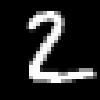

In [ ]:
test_image = mnist_test_data[1]

norm_image = cv2.normalize(test_image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
norm_image = cv2.resize(norm_image, (100,100), interpolation=cv2.INTER_NEAREST)
cv2_imshow(norm_image)

In [ ]:
# Create model
cy_mnist_test_model = sequential()
cy_mnist_test_model.add_conv2d(n_filter=6, filter_size=(3,3), input_width=(1,28,28), strides=(1,1), activation="relu")
cy_mnist_test_model.add_averagepooling2d(pool_size=(2,2), strides=(1,1))
cy_mnist_test_model.add_flattern()
cy_mnist_test_model.add_fc(n_neuron=64, activation="relu")
cy_mnist_test_model.add_fc(n_neuron=10, activation="softmax")

# Load weight
weights = np.load('./mnist_result/weights_12-14-2020,16:07.npz',allow_pickle=True)['weight']
cy_mnist_test_model.load_weight(weights)

# Predict
predict = cy_mnist_test_model.predict(test_image.reshape(1,1,28,28))

predict = (predict == predict.max(axis=1)[:,None]).astype(int)

### Filter

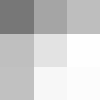

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

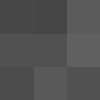

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

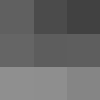

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

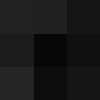

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

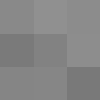

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

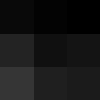

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Normalize through all filter
filter = cy_mnist_test_model.n_layer[0].weight.reshape(6,3,3)
norm_filter = cv2.normalize(filter, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
for idx,img in enumerate(norm_filter):
  norm_image = cv2.resize(img,(100,100), interpolation=cv2.INTER_NEAREST)
  norm_image.astype(np.uint8)
  cv2_imshow(norm_image)
  cv2.imwrite("f"+str(idx)+".png",norm_image)
  files.download("f"+str(idx)+".png")
  print()

### Output after Conv2d

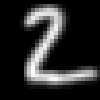

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

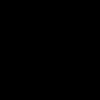

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

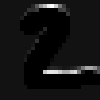

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

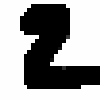

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

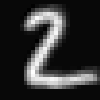

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

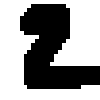

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Normalize each feature map
filtered = cy_mnist_test_model.n_layer[0].out
for idx,img in enumerate(filtered):
  norm_image = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
  norm_image = cv2.resize(norm_image,(100,100), interpolation=cv2.INTER_NEAREST)
  norm_image.astype(np.uint8)
  cv2_imshow(norm_image)
  cv2.imwrite("2c"+str(idx+1)+".png",norm_image)
  files.download("2c"+str(idx+1)+".png")
  print()

### Output after pooling

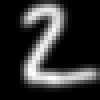

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

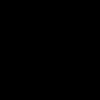

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

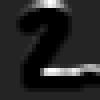

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

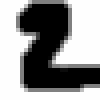

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

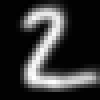

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

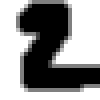

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
filtered = cy_mnist_test_model.n_layer[1].out
for idx,img in enumerate(filtered):
  norm_image = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
  norm_image = cv2.resize(norm_image,(100,100), interpolation=cv2.INTER_NEAREST)
  norm_image.astype(np.uint8)
  cv2_imshow(norm_image)
  cv2.imwrite("2p"+str(idx+1)+".png",norm_image)
  files.download("2p"+str(idx+1)+".png")
  print()